https://www.tensorflow.org/guide/core/mlp_core

In [3]:
#! pip install tensorflow
# !pip install tensorflow_datasets
# !pip install matplotlib

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [5]:
train_data, val_data, test_data = tfds.load("mnist", 
                                            split=['train[10000:]', 'train[0:10000]', 'test'],
                                            batch_size=128, as_supervised=True)

images, label = tfds.load("mnist", split=['train[:1500]'], batch_size=-1, as_supervised=True)[0]
# images = tf.squeeze(images, axis=3)


2024-07-26 09:31:49.405240: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [6]:
images.shape

TensorShape([1500, 28, 28, 1])

In [14]:
image_mlp = tf.cast(tf.reshape(images, [1500, 28*28*1]),tf.float32) # Переводим в вектор

In [20]:
image_mlp.shape

TensorShape([1500, 784])

In [21]:
class MyLayer(tf.Module):
    def __init__(self, size_input, size_output, func):
        super().__init__()
        self.size_output = size_output
        self.size_input = size_input
        self.w0 = tf.Variable(tf.random.normal([size_input, size_output],mean=0, stddev=0.001))
        self.b = tf.Variable(tf.random.normal([size_output, ], mean=1, stddev=0.001))
        self.sigma = func
        
    @tf.function()
    def __call__(self, x):
        
        z = tf.add(tf.matmul(x, self.w0), self.b)
        return self.sigma(z)


In [22]:
mylayer = MyLayer(size_input=784, size_output=2, func=tf.nn.relu)

In [24]:
mylayer(image_mlp)

<tf.Tensor: shape=(1500, 2), dtype=float32, numpy=
array([[0.12685335, 2.9195418 ],
       [0.        , 2.414944  ],
       [0.29637098, 7.239004  ],
       ...,
       [2.5181353 , 1.7668834 ],
       [2.8647594 , 1.7602656 ],
       [0.        , 5.062666  ]], dtype=float32)>

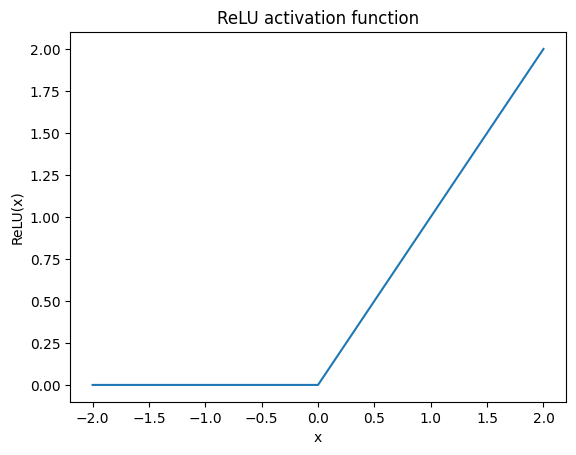

In [25]:
x = tf.linspace(-2, 2, 201)
x = tf.cast(x, tf.float32)
plt.plot(x, tf.nn.relu(x));
plt.xlabel('x')
plt.ylabel('ReLU(x)')
plt.title('ReLU activation function');

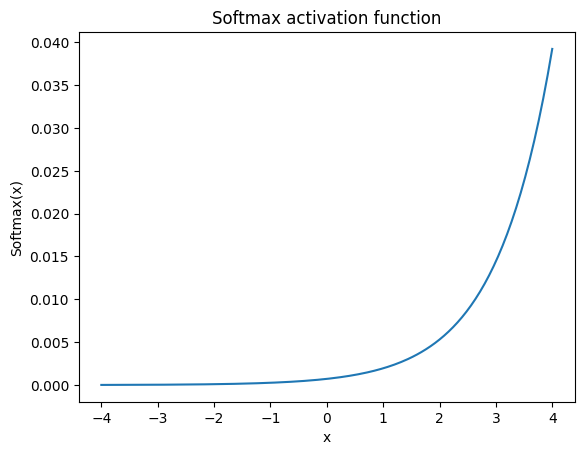

In [26]:
x = tf.linspace(-4, 4, 201)
x = tf.cast(x, tf.float32)
plt.plot(x, tf.nn.softmax(x, axis=0));
plt.xlabel('x')
plt.ylabel('Softmax(x)')
plt.title('Softmax activation function');

In [27]:
class MLP(tf.Module):
    def __init__(self, layers):
        self.layers = layers

    @tf.function
    def __call__(self, x, preds=False): 
        # Execute the model's layers sequentially
        for layer in self.layers:
            x = layer(x)
        return x

In [28]:
mlp_model = MLP([MyLayer(size_input=784, size_output=196, func=tf.nn.relu),
     MyLayer(size_input=196, size_output=50, func=tf.nn.relu),
     MyLayer(size_input=50, size_output=10, func=tf.nn.softmax)])

In [44]:
@tf.function
def cross_entropy_loss(y_pred, y):
    # Compute cross entropy loss with a sparse operation
    sparse_ce = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=y_pred)
    return tf.reduce_mean(sparse_ce)


def accuracy(y_pred, y):
    # Compute accuracy after extracting class predictions
    class_preds = tf.argmax(tf.nn.softmax(y_pred), axis=1)
    is_equal = tf.equal(y, class_preds)
    return tf.reduce_mean(tf.cast(is_equal, tf.float32))

In [45]:
class Adam:
    # Подробно изучить адам
    def __init__(self, learning_rate=1e-3, beta_1=0.9, beta_2=0.999, ep=1e-7):
      # Initialize optimizer parameters and variable slots
      self.beta_1 = beta_1
      self.beta_2 = beta_2
      self.learning_rate = learning_rate
      self.ep = ep
      self.t = 1.
      self.v_dvar, self.s_dvar = [], []
      self.built = False

    def apply_gradients(self, grads, vars):
      # Initialize variables on the first call
      if not self.built:
        for var in vars:
          v = tf.Variable(tf.zeros(shape=var.shape))
          s = tf.Variable(tf.zeros(shape=var.shape))
          self.v_dvar.append(v)
          self.s_dvar.append(s)
        self.built = True
      # Update the model variables given their gradients
      for i, (d_var, var) in enumerate(zip(grads, vars)):
        self.v_dvar[i].assign(self.beta_1*self.v_dvar[i] + (1-self.beta_1)*d_var)
        self.s_dvar[i].assign(self.beta_2*self.s_dvar[i] + (1-self.beta_2)*tf.square(d_var))
        v_dvar_bc = self.v_dvar[i]/(1-(self.beta_1**self.t))
        s_dvar_bc = self.s_dvar[i]/(1-(self.beta_2**self.t))
        var.assign_sub(self.learning_rate*(v_dvar_bc/(tf.sqrt(s_dvar_bc) + self.ep)))
      self.t += 1.
      return

In [56]:

history_loss = []
def train_step(x_batch, y_batch, loss, acc, model, optimizer):
  # Update the model state given a batch of data
  with tf.GradientTape() as tape:
    y_pred = model(x_batch)
    batch_loss = loss(y_pred, y_batch)
    history_loss.append(batch_loss)
  batch_acc = acc(y_pred, y_batch)
  grads = tape.gradient(batch_loss, model.variables)
  optimizer.apply_gradients(grads, model.variables)
  
  return batch_loss, batch_acc

def val_step(x_batch, y_batch, loss, acc, model):
  # Evaluate the model on given a batch of validation data
  y_pred = model(x_batch)
  batch_loss = loss(y_pred, y_batch)
  batch_acc = acc(y_pred, y_batch)
  return batch_loss, batch_acc

In [57]:
def train_model(mlp, train_data, val_data, loss, acc, optimizer, epochs):
  # Метрики
  train_losses, train_accs = [], []
  val_losses, val_accs = [], []

  # Обучение на несколько эпох
  for epoch in range(epochs):
    batch_losses_train, batch_accs_train = [], []
    batch_losses_val, batch_accs_val = [], []

    # Обучение по батчам
    for x_batch, y_batch in train_data:
      # шаг обучения 
      batch_loss, batch_acc = train_step(x_batch, y_batch, loss, acc, mlp, optimizer)
      # созранение параметров
      batch_losses_train.append(batch_loss)
      batch_accs_train.append(batch_acc)

    # Валидация
    for x_batch, y_batch in val_data:
      batch_loss, batch_acc = val_step(x_batch, y_batch, loss, acc, mlp)
      batch_losses_val.append(batch_loss)
      batch_accs_val.append(batch_acc)

    # Среднее значения по показателям
    train_loss, train_acc = tf.reduce_mean(batch_losses_train), tf.reduce_mean(batch_accs_train)
    val_loss, val_acc = tf.reduce_mean(batch_losses_val), tf.reduce_mean(batch_accs_val)

    # Сохранение
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Вывод
    print(f"Epoch: {epoch}")
    print(f"Training loss: {train_loss:.3f}, Training accuracy: {train_acc:.3f}")
    print(f"Validation loss: {val_loss:.3f}, Validation accuracy: {val_acc:.3f}")
  return train_losses, train_accs, val_losses, val_accs

In [58]:

def preprocess(x, y):
  # Reshaping the data
  x = tf.reshape(x, shape=[-1, 784])
  # Rescaling the data
  x = x/255
  return x, y

train_data_prep, val_data_prep = train_data.map(preprocess), val_data.map(preprocess)

In [59]:
train_losses, train_accs, val_losses, val_accs = train_model(mlp_model, train_data_prep, val_data_prep, 
                                                             loss=cross_entropy_loss, acc=accuracy,
                                                             optimizer=Adam(), epochs=10)

Epoch: 0
Training loss: 1.497, Training accuracy: 0.966
Validation loss: 1.506, Validation accuracy: 0.956
Epoch: 1
Training loss: 1.494, Training accuracy: 0.968
Validation loss: 1.503, Validation accuracy: 0.958
Epoch: 2
Training loss: 1.492, Training accuracy: 0.971
Validation loss: 1.502, Validation accuracy: 0.960
Epoch: 3
Training loss: 1.489, Training accuracy: 0.974
Validation loss: 1.499, Validation accuracy: 0.962
Epoch: 4
Training loss: 1.487, Training accuracy: 0.976
Validation loss: 1.499, Validation accuracy: 0.963


2024-07-26 09:54:53.047876: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch: 5
Training loss: 1.485, Training accuracy: 0.977
Validation loss: 1.497, Validation accuracy: 0.965
Epoch: 6
Training loss: 1.483, Training accuracy: 0.979
Validation loss: 1.497, Validation accuracy: 0.964
Epoch: 7
Training loss: 1.482, Training accuracy: 0.980
Validation loss: 1.496, Validation accuracy: 0.965
Epoch: 8
Training loss: 1.480, Training accuracy: 0.982
Validation loss: 1.494, Validation accuracy: 0.968
Epoch: 9
Training loss: 1.480, Training accuracy: 0.983
Validation loss: 1.496, Validation accuracy: 0.966


In [60]:
mlp_model.variables

(<tf.Variable 'Variable:0' shape=(196,) dtype=float32, numpy=
 array([0.81308717, 0.785932  , 0.8127935 , 0.8587173 , 0.8122646 ,
        0.83894104, 0.7304039 , 0.7950865 , 0.83491135, 0.76190764,
        0.90163773, 0.8281468 , 0.8543775 , 0.86547697, 1.0164751 ,
        0.8629589 , 0.94521856, 0.90737003, 1.0238847 , 0.9149169 ,
        0.8636962 , 0.9627043 , 0.90084577, 0.9310211 , 0.90276676,
        0.7961387 , 0.84167176, 0.7571072 , 0.7629309 , 0.9233565 ,
        0.7869786 , 1.2148359 , 1.2383547 , 0.7354189 , 0.953692  ,
        0.7177369 , 0.79033947, 0.77133983, 0.9103037 , 1.233723  ,
        0.7599862 , 0.77723366, 0.91632175, 1.0777597 , 0.99349856,
        0.8156037 , 0.9985829 , 0.9997829 , 0.81948334, 0.83794045,
        0.73456055, 0.744515  , 0.83358306, 0.7988593 , 0.8499018 ,
        0.9858852 , 0.9237123 , 0.84508646, 0.82067066, 0.81281227,
        1.0259194 , 0.8478567 , 1.2463204 , 0.8765239 , 0.8846415 ,
        0.7468232 , 0.9979793 , 0.7412679 , 1.195637  

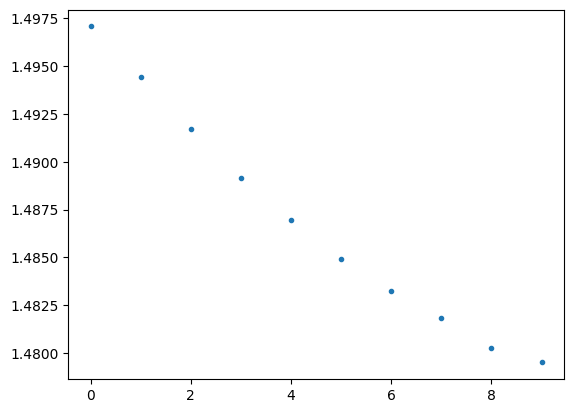

In [66]:
plt.plot(train_losses, '.')

3910